In [1]:
import os
import sys
sys.path.insert(0,'/home/junwoony/Desktop/Differentiable_Optimization_GCN/Differentiable_Optimization_GCN/')

import numpy as np
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_LAUNCH_BLOCKING=1

import json
import mongo
import time
import pickle
import random
import numpy as np
import tqdm
import copy
import matplotlib.pyplot as plt
import multiprocess as mp
import seaborn as sns
import pandas as pd
from pymatgen.io.ase import AseAtomsAdaptor

import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torch.optim.lbfgs import LBFGS
from cgcnn.data_orbital import StructureData, ListDataset, StructureDataTransformer, collate_pool, MergeDataset
from cgcnn.model import CrystalGraphConvNet

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.metrics import get_scorer
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, LoadInitState #needs skorch 0.4.0, conda-forge version at 0.3.0 doesn't cut it
import skorch.callbacks.base
from skorch.dataset import CVSplit
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler

from utils.adamwr.adamw import AdamW
from utils.adamwr.cosine_scheduler import CosineLRWithRestarts


from sigopt_sklearn.search import SigOptSearchCV


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
env: CUDA_LAUNCH_BLOCKING=1


In [2]:
SDT_list = pickle.load(open('../../input_H_ads/SDT_list.pkl', 'rb'))
docs = pickle.load(open('../../input_H_ads/final_docs.pkl', 'rb'))

# SDT_list = pickle.load(open('../../../cgcnn/bond_regression3/new3/SDT_list.pkl', 'rb'))
# docs = pickle.load(open('../../../cgcnn/bond_regression3/new3/final_docs.pkl', 'rb'))

# target_list = pickle.load(open('../../../cgcnn/bond_regression3/new2/target_list.pkl', 'rb'))
# target_list = pickle.load(open('../../../cgcnn/bond_regression3/new2/target_list_mse.pkl', 'rb'))

structures = SDT_list[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]



In [3]:
target_list = []
SDT_list_new = []
docs_new = []
for i, sdt in enumerate(SDT_list):
    atom_pos_final = sdt[-1]
    nbr_fea_idx = sdt[2]
    nbr_fea_offset = sdt[3]
    cells = sdt[7]
    ads_idx_base = sdt[-4]
    ads_idx = np.where(ads_idx_base == 1)[0]

    nbr_pos = atom_pos_final[nbr_fea_idx]
    differ = nbr_pos - atom_pos_final.unsqueeze(1) + torch.bmm(nbr_fea_offset, cells)
    differ_sum = torch.sum(differ**2, dim=2)
    distance = torch.sqrt(differ_sum).unsqueeze(-1)
    
    if np.min(distance.numpy()) == 0:
        print(i)
    else:
#         target_list.append(distance.numpy())
        SDT_list_new.append(sdt)
        docs_new.append(docs[i])
# target_list = np.array(target_list).reshape(-1,1)

SDT_list = SDT_list_new
docs = docs_new
target_list = np.array([sdt[-1][sdt[-2]].numpy() for sdt in SDT_list]).reshape(-1,1) #get final_pos of free atoms ONLY

In [4]:
# ### ONLY ADSORBATE
# target_list = []
# for i, sdt in enumerate(SDT_list):
#     atom_pos_final = sdt[-1]
#     nbr_fea_idx = sdt[2]
#     nbr_fea_offset = sdt[3]
#     cells = sdt[7]
#     ads_idx_base = sdt[-4]
#     ads_idx = np.where(ads_idx_base == 1)[0]

#     nbr_pos = atom_pos_final[nbr_fea_idx][ads_idx]
#     differ = nbr_pos - atom_pos_final[ads_idx].unsqueeze(1) + torch.bmm(nbr_fea_offset[ads_idx], cells[ads_idx])
#     differ_sum = torch.sum(differ**2, dim=2)
#     distance = torch.sqrt(differ_sum).unsqueeze(-1)
    
#     if np.min(distance.numpy()) == 0:
#         print(i)
#     else:
#         target_list.append(distance.numpy())
# target_list = np.array(target_list).reshape(len(SDT_list),-1)

In [5]:
# np.concatenate(target_list.reshape(-1)).shape

In [6]:
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device='cpu'

#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best',fn_prefix='./H_ads/valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training

class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./H_ads/valid_best_params.pt')
        
load_best_valid_loss = train_end_load_best_valid_loss()
print('device:', device)

device: cuda


In [33]:
def get_distance(atom_pos, nbr_fea_idx, nbr_fea_offset, cells):
    nbr_pos = atom_pos[nbr_fea_idx]
    differ = nbr_pos - atom_pos.unsqueeze(1) + torch.bmm(nbr_fea_offset, cells)
    differ_sum = torch.sum(differ**2, dim=2)
    distance = torch.sqrt(differ_sum).unsqueeze(-1)            
    return distance

differences, differences_ads, differences_non_ads_free = [], [], []
dist_free, dist_ads, dist_non_ads =[],[], []
SDT_list_new, docs_new, target_list_new = [], [], []

c = 0
max_num_nbr = 12

for i, sdt in enumerate(SDT_list):
    nbr_fea_idx = sdt[2]
    nbr_fea_offset = sdt[3]
    atom_pos =sdt[4]
    cells = sdt[7]
    atom_pos_final = sdt[-1]
    free_atom_idx = sdt[-2]
    ads_idx_base = sdt[-4]
    ads_tag = np.where(ads_idx_base == 1)[0]
    non_ads_tag = np.sort(np.array(list(set(free_atom_idx.numpy()) ^ set(ads_tag))))

    if torch.mean(torch.sqrt(torch.sum((atom_pos-atom_pos_final)[ads_tag]**2, dim=1))) < 2:
        SDT_list_new.append(sdt)
        target_list_new.append(target_list[i])
        docs_new.append(docs[i])

        dist_free.append(torch.sqrt(torch.sum((atom_pos - atom_pos_final)[free_atom_idx]**2, dim=1)))
        dist_ads.append(torch.sqrt(torch.sum((atom_pos-atom_pos_final)[ads_tag]**2, dim=1)))
        dist_non_ads.append(torch.sqrt(torch.sum((atom_pos-atom_pos_final)[non_ads_tag]**2, dim=1)))

        bond_distance = get_distance(atom_pos, nbr_fea_idx, nbr_fea_offset, cells)
        final_distance = get_distance(atom_pos_final, nbr_fea_idx, nbr_fea_offset, cells)
        N, M, C = bond_distance.shape
        bond_distance = bond_distance #* fake_nbr.float().expand(N, M, C)    
        final_distance = final_distance #* fake_nbr.float().expand(N, M, C) 

        c += len(atom_pos) * max_num_nbr
    #     differences.append((torch.sqrt(torch.tensor(10.))*final_distance - torch.sqrt(torch.tensor(10.))*bond_distance).view(-1))
        differences.append((final_distance - bond_distance).view(-1))
        differences_ads.append((final_distance - bond_distance).view(-1)[ads_tag])
        differences_non_ads_free.append((final_distance - bond_distance).view(-1)[non_ads_tag])

differences = torch.cat(differences)**2
differences_ads = torch.cat(differences_ads)**2
differences_non_ads_free = torch.cat(differences_non_ads_free)**2

# differences = torch.clamp(differences, min=1e-8)
assert c == len(differences)
# dist_err = torch.mean(torch.abs(differences))
# torch.log(dist_err)
# dist_err = torch.mean(torch.sqrt(differences))
dist_err = torch.mean(differences)
dist_err_ads = torch.mean(differences_ads)
dist_err_non_ads_free = torch.mean(differences_non_ads_free)

print('bond_distance:',dist_err, dist_err_ads, dist_err_non_ads_free)
print('x:',torch.mean(torch.cat(dist_free)), torch.mean(torch.cat(dist_ads)), torch.mean(torch.cat(dist_non_ads)))


bond_distance: tensor(0.0140) tensor(0.1951) tensor(0.0792)
x: tensor(0.1377) tensor(0.8033) tensor(0.0857)


In [27]:
torch.cat(dist_non_ads)

tensor([0.0598, 0.0455, 0.0456,  ..., 0.1724, 0.3220, 0.0761])

(array([1.740e+02, 1.376e+03, 1.970e+03, 1.786e+03, 1.427e+03, 1.095e+03,
        7.870e+02, 7.440e+02, 5.830e+02, 4.630e+02, 2.990e+02, 2.600e+02,
        1.760e+02, 1.270e+02, 6.000e+01, 5.500e+01, 2.100e+01, 2.100e+01,
        1.000e+00, 1.000e+00]),
 array([0.00689821, 0.02237705, 0.03785589, 0.05333472, 0.06881356,
        0.0842924 , 0.09977124, 0.11525007, 0.13072892, 0.14620775,
        0.16168658, 0.17716543, 0.19264427, 0.2081231 , 0.22360194,
        0.23908079, 0.2545596 , 0.27003846, 0.2855173 , 0.30099612,
        0.31647497], dtype=float32),
 <a list of 20 Patch objects>)

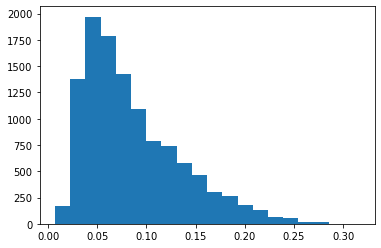

In [8]:
m = []
for dist in dist_non_ads:
    m.append(torch.mean(dist))
plt.hist(m,bins=20)

In [34]:
target_list_new = np.array(target_list_new)
SDT_training, SDT_test, target_training, target_test, docs_training, docs_test \
= train_test_split(SDT_list_new, target_list_new, docs_new, test_size=0.15, random_state=42)

In [10]:
### DIfferent target for SigOpt and actual run.
### This is for actual x_min prediction

def diff_position(sdt, target, adsorbate=False):
    if not adsorbate:
        fixed_base = sdt[-3]
        free_atom_idx = np.where(fixed_base == 0)[0]
        free_atom_idx = torch.LongTensor(free_atom_idx)   
        diff = (target[0] - sdt[4].numpy()[free_atom_idx])
    else:
        ads_tag = sdt[-4]
        ads_idx = np.where(ads_tag == 1)[0]
        diff = (target[0] - sdt[4].numpy())[ads_idx]
    return diff

differences = []
for sdt, target in zip(SDT_training, target_training):
    differences.append(diff_position(sdt, target))
differences = np.concatenate(differences)

# differences_ads = []
# for sdt, target in zip(SDT_training, target_training):
#     differences_ads.append(diff_position(sdt, target, adsorbate=True))
# differences_ads = np.concatenate(differences_ads)

print('all free atoms',np.mean(np.abs(differences)))
# print('ads only',np.mean(np.abs(differences_ads)))

all free atoms 0.0663925


In [11]:
from torch.optim import lr_scheduler
import torch.optim as optim


# train_test_splitter = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_test_splitter = ShuffleSplit(n_splits=1, test_size=0.1, random_state=22)


batchsize = 20
# warm restart scheduling from https://arxiv.org/pdf/1711.05101.pdf
# LR_schedule = LRScheduler(CosineLRWithRestarts, batch_size=batchsize, epoch_size=len(SDT_training), restart_period=10, t_mult=1.2)

#### For Sigopt
LR_schedule = LRScheduler("MultiStepLR", milestones=[100], gamma=0.1)

#############
# To extract intermediate features, set the forward takes only the first return value to calculate loss
class MyNet(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, **kwargs):
        y_pred = y_pred[0] if isinstance(y_pred, tuple) else y_pred  # discard the 2nd output
        differ=torch.sum((y_pred-y_true.cuda())**2.0,dim=1)
        if torch.nonzero(differ).shape[0] != differ.shape[0]:
            print('zero sqrt for Loss')
#             zero_idx = (differ == 0).nonzero()
#             differ[zero_idx] = 1e-6
        differ = torch.clamp(differ, min=1e-8)

        return torch.mean(torch.sqrt(differ))


net = MyNet(
    CrystalGraphConvNet,
    module__orig_atom_fea_len = orig_atom_fea_len,
    module__nbr_fea_len = nbr_fea_len,
    batch_size=batchsize, #214
    module__classification=False,
    lr=00.028446171826811632,
    max_epochs= 200,
    module__energy_mode="Harmonic", #["Harmonic", "Morse", "LJ"], Default = "Harmonic"
    module__atom_fea_len=128, #46,
    module__h_fea_len=105,
    module__h_fea_len_dist=71,
    module__h_fea_len_const=71,
#     module__h_fea_len_D=(3,256),
    module__n_conv=9, #8
    module__n_h_dist=0,
    module__n_h_const=0,
    optimizer__weight_decay=0.000045399929762484854,
#     module__n_h_D=(1,12),
#     module__max_num_nbr=12, #9
#     module__opt_step_size=(0.1,0.7), #0.3
    module__min_opt_steps=30,
    module__max_opt_steps=150,
    module__momentum=0.8,
    optimizer=AdamW,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__shuffle=True,
    iterator_train__collate_fn = collate_pool,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    device=device,
#     criterion=torch.nn.MSELoss,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    train_split = CVSplit(cv=train_test_splitter),
    callbacks=[cp,LR_schedule , load_best_valid_loss],

)


net.initialize()
net.load_params(f_history = './H_ads/valid_best_history.json',
               f_optimizer = './H_ads/valid_best_optimizer.pt',
               f_params = './H_ads/valid_best_params.pt')



In [12]:
net.load_params('./H_ads/valid_best_optimizer.pt')

RuntimeError: Error(s) in loading state_dict for CrystalGraphConvNet:
	Missing key(s) in state_dict: "embedding.weight", "embedding.bias", "convs.0.fc_full.weight", "convs.0.fc_full.bias", "convs.0.bn1.weight", "convs.0.bn1.bias", "convs.0.bn1.running_mean", "convs.0.bn1.running_var", "convs.0.bn2.weight", "convs.0.bn2.bias", "convs.0.bn2.running_mean", "convs.0.bn2.running_var", "convs.0.fc_full2.weight", "convs.0.fc_full2.bias", "convs.0.nbr_bn1.weight", "convs.0.nbr_bn1.bias", "convs.0.nbr_bn1.running_mean", "convs.0.nbr_bn1.running_var", "convs.0.nbr_bn2.weight", "convs.0.nbr_bn2.bias", "convs.0.nbr_bn2.running_mean", "convs.0.nbr_bn2.running_var", "convs.1.fc_full.weight", "convs.1.fc_full.bias", "convs.1.bn1.weight", "convs.1.bn1.bias", "convs.1.bn1.running_mean", "convs.1.bn1.running_var", "convs.1.bn2.weight", "convs.1.bn2.bias", "convs.1.bn2.running_mean", "convs.1.bn2.running_var", "convs.1.fc_full2.weight", "convs.1.fc_full2.bias", "convs.1.nbr_bn1.weight", "convs.1.nbr_bn1.bias", "convs.1.nbr_bn1.running_mean", "convs.1.nbr_bn1.running_var", "convs.1.nbr_bn2.weight", "convs.1.nbr_bn2.bias", "convs.1.nbr_bn2.running_mean", "convs.1.nbr_bn2.running_var", "convs.2.fc_full.weight", "convs.2.fc_full.bias", "convs.2.bn1.weight", "convs.2.bn1.bias", "convs.2.bn1.running_mean", "convs.2.bn1.running_var", "convs.2.bn2.weight", "convs.2.bn2.bias", "convs.2.bn2.running_mean", "convs.2.bn2.running_var", "convs.2.fc_full2.weight", "convs.2.fc_full2.bias", "convs.2.nbr_bn1.weight", "convs.2.nbr_bn1.bias", "convs.2.nbr_bn1.running_mean", "convs.2.nbr_bn1.running_var", "convs.2.nbr_bn2.weight", "convs.2.nbr_bn2.bias", "convs.2.nbr_bn2.running_mean", "convs.2.nbr_bn2.running_var", "convs.3.fc_full.weight", "convs.3.fc_full.bias", "convs.3.bn1.weight", "convs.3.bn1.bias", "convs.3.bn1.running_mean", "convs.3.bn1.running_var", "convs.3.bn2.weight", "convs.3.bn2.bias", "convs.3.bn2.running_mean", "convs.3.bn2.running_var", "convs.3.fc_full2.weight", "convs.3.fc_full2.bias", "convs.3.nbr_bn1.weight", "convs.3.nbr_bn1.bias", "convs.3.nbr_bn1.running_mean", "convs.3.nbr_bn1.running_var", "convs.3.nbr_bn2.weight", "convs.3.nbr_bn2.bias", "convs.3.nbr_bn2.running_mean", "convs.3.nbr_bn2.running_var", "convs.4.fc_full.weight", "convs.4.fc_full.bias", "convs.4.bn1.weight", "convs.4.bn1.bias", "convs.4.bn1.running_mean", "convs.4.bn1.running_var", "convs.4.bn2.weight", "convs.4.bn2.bias", "convs.4.bn2.running_mean", "convs.4.bn2.running_var", "convs.4.fc_full2.weight", "convs.4.fc_full2.bias", "convs.4.nbr_bn1.weight", "convs.4.nbr_bn1.bias", "convs.4.nbr_bn1.running_mean", "convs.4.nbr_bn1.running_var", "convs.4.nbr_bn2.weight", "convs.4.nbr_bn2.bias", "convs.4.nbr_bn2.running_mean", "convs.4.nbr_bn2.running_var", "convs.5.fc_full.weight", "convs.5.fc_full.bias", "convs.5.bn1.weight", "convs.5.bn1.bias", "convs.5.bn1.running_mean", "convs.5.bn1.running_var", "convs.5.bn2.weight", "convs.5.bn2.bias", "convs.5.bn2.running_mean", "convs.5.bn2.running_var", "convs.5.fc_full2.weight", "convs.5.fc_full2.bias", "convs.5.nbr_bn1.weight", "convs.5.nbr_bn1.bias", "convs.5.nbr_bn1.running_mean", "convs.5.nbr_bn1.running_var", "convs.5.nbr_bn2.weight", "convs.5.nbr_bn2.bias", "convs.5.nbr_bn2.running_mean", "convs.5.nbr_bn2.running_var", "convs.6.fc_full.weight", "convs.6.fc_full.bias", "convs.6.bn1.weight", "convs.6.bn1.bias", "convs.6.bn1.running_mean", "convs.6.bn1.running_var", "convs.6.bn2.weight", "convs.6.bn2.bias", "convs.6.bn2.running_mean", "convs.6.bn2.running_var", "convs.6.fc_full2.weight", "convs.6.fc_full2.bias", "convs.6.nbr_bn1.weight", "convs.6.nbr_bn1.bias", "convs.6.nbr_bn1.running_mean", "convs.6.nbr_bn1.running_var", "convs.6.nbr_bn2.weight", "convs.6.nbr_bn2.bias", "convs.6.nbr_bn2.running_mean", "convs.6.nbr_bn2.running_var", "convs.7.fc_full.weight", "convs.7.fc_full.bias", "convs.7.bn1.weight", "convs.7.bn1.bias", "convs.7.bn1.running_mean", "convs.7.bn1.running_var", "convs.7.bn2.weight", "convs.7.bn2.bias", "convs.7.bn2.running_mean", "convs.7.bn2.running_var", "convs.7.fc_full2.weight", "convs.7.fc_full2.bias", "convs.7.nbr_bn1.weight", "convs.7.nbr_bn1.bias", "convs.7.nbr_bn1.running_mean", "convs.7.nbr_bn1.running_var", "convs.7.nbr_bn2.weight", "convs.7.nbr_bn2.bias", "convs.7.nbr_bn2.running_mean", "convs.7.nbr_bn2.running_var", "convs.8.fc_full.weight", "convs.8.fc_full.bias", "convs.8.bn1.weight", "convs.8.bn1.bias", "convs.8.bn1.running_mean", "convs.8.bn1.running_var", "convs.8.bn2.weight", "convs.8.bn2.bias", "convs.8.bn2.running_mean", "convs.8.bn2.running_var", "convs.8.fc_full2.weight", "convs.8.fc_full2.bias", "convs.8.nbr_bn1.weight", "convs.8.nbr_bn1.bias", "convs.8.nbr_bn1.running_mean", "convs.8.nbr_bn1.running_var", "convs.8.nbr_bn2.weight", "convs.8.nbr_bn2.bias", "convs.8.nbr_bn2.running_mean", "convs.8.nbr_bn2.running_var", "bond_distance.weight", "bond_distance.bias", "bond_distance_bn.weight", "bond_distance_bn.bias", "bond_distance_bn.running_mean", "bond_distance_bn.running_var", "bond_constant.weight", "bond_constant.bias", "bond_constant_bn.weight", "bond_constant_bn.bias", "bond_constant_bn.running_mean", "bond_constant_bn.running_var", "bond_distance2.weight", "bond_distance2.bias", "bond_constant2.weight", "bond_constant2.bias". 
	Unexpected key(s) in state_dict: "state", "param_groups". 

In [18]:
net.get_params()

{'module': cgcnn.model.CrystalGraphConvNet,
 'criterion': torch.nn.modules.loss.L1Loss,
 'optimizer': utils.adamwr.adamw.AdamW,
 'lr': 0.028446171826811632,
 'max_epochs': 200,
 'batch_size': 20,
 'iterator_train': torch.utils.data.dataloader.DataLoader,
 'iterator_valid': torch.utils.data.dataloader.DataLoader,
 'dataset': cgcnn.data_orbital.MergeDataset,
 'train_split': <skorch.dataset.CVSplit object at 0x7f39b7ac8c18>,
 'callbacks': [<skorch.callbacks.training.Checkpoint at 0x7f3a1370db38>,
 'warm_start': False,
 'verbose': 1,
 'device': device(type='cuda'),
 'module__orig_atom_fea_len': 142,
 'module__nbr_fea_len': 27,
 'module__classification': False,
 'module__energy_mode': 'Harmonic',
 'module__atom_fea_len': 128,
 'module__h_fea_len': 105,
 'module__h_fea_len_dist': 71,
 'module__h_fea_len_const': 71,
 'module__n_conv': 9,
 'module__n_h_dist': 0,
 'module__n_h_const': 0,
 'optimizer__weight_decay': 4.5399929762484854e-05,
 'module__min_opt_steps': 30,
 'module__max_opt_steps': 

In [15]:
SDT_train, SDT_valid, target_train, target_valid = train_test_split(SDT_training, target_training, 
                                                                    test_size=0.1, random_state=42)
def get_targets(dummy_SDT, dummy_targets):
    targets = []
    for i, target in enumerate(dummy_targets):
        free_atom_idx = dummy_SDT[i][-2]
        targets.append(target[0].reshape(-1,3))
        assert len(free_atom_idx) == len(target[0])
    return np.concatenate(targets)

def get_distance(pred, true):
    diff = np.sum((pred - true)**2, axis=1)
    return np.sqrt(diff)

def get_initial(dummy_SDT):
    init_test = []
    for sdt in dummy_SDT:
        free_atom_idx = sdt[-2]
        atom_pos = sdt[4][free_atom_idx]
        init_test.append(atom_pos)
    return np.concatenate(init_test)
        

In [16]:
# pred_train = net.predict(SDT_train)
# true_train = get_targets(SDT_train, target_train)
# distance_train = get_distance(pred_train, true_train)
# MAE_train = np.mean(distance_train)

# pred_val = net.predict(SDT_valid)
# true_val = get_targets(SDT_valid, target_valid)
# distance_val = get_distance(pred_val, true_val)
# MAE_val = np.mean(distance_val)

# init_test = get_initial(SDT_test)
# pred_test = net.predict(SDT_test)
# true_test = get_targets(SDT_test, target_test)

init_test = pickle.load(open('./H_ads/init_test.pkl', 'rb'))
pred_test = pickle.load(open('./H_ads/pred_test.pkl', 'rb'))
true_test = pickle.load(open('./H_ads/true_test.pkl', 'rb'))

distance_test = get_distance(pred_test, true_test)
distance_pred_initial = get_distance(pred_test, init_test)
distance_init = get_distance(init_test, true_test)

###### Per ATOM MAE ##### (NOT per structure MAE)

MAE_pred_final = np.mean(distance_test)
MAE_pred_initial = np.mean(distance_pred_initial)
MAE_initial_final = np.mean(distance_init)

torch.cuda.empty_cache()

In [17]:
# pickle.dump(init_test, open('./H_ads/init_test.pkl', 'wb'))
# pickle.dump(pred_test, open('./H_ads/pred_test.pkl', 'wb'))
# pickle.dump(true_test, open('./H_ads/true_test.pkl', 'wb'))

In [18]:
print(MAE_pred_final, MAE_pred_initial, MAE_initial_final)
print(MAE_pred_final/MAE_initial_final, 1 - MAE_pred_final/MAE_initial_final)

0.07620042 0.114107735 0.13816118
0.55153275 0.4484672546386719


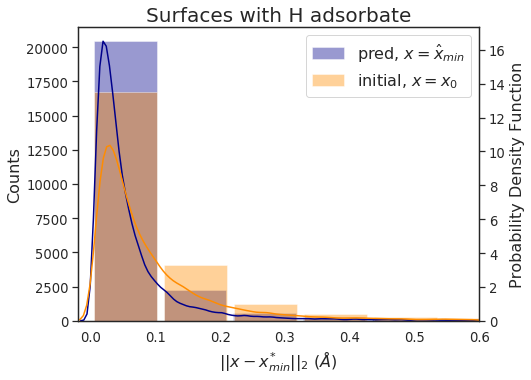

In [24]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7.2, 5.4)})
sns.set(font_scale = 1.2)
# sns.set_style("whitegrid")
sns.set_style("white")

# idx = np.where(distance_test < 0.6)[0]
# idx_init = np.where(distance_init < 0.6)[0]

# ax = sns.distplot(distance_test[idx], bins=50, kde=False, norm_hist=False, color='darkblue', label='pred, $x = \hat{x}_{min}$'
#                  ,hist_kws={"rwidth":0.9})
# ax = sns.distplot(distance_init[idx_init], bins=50, kde=False,norm_hist=False, color='darkorange', label='initial, $x = x_{0}$'
#                  ,hist_kws={"rwidth":0.9})
ax = sns.distplot(distance_test, bins=50, kde=False, norm_hist=False, color='darkblue', label='pred, $x = \hat{x}_{min}$'
                 ,hist_kws={"rwidth":0.9})
ax = sns.distplot(distance_init, bins=50, kde=False,norm_hist=False, color='darkorange', label='initial, $x = x_{0}$'
                 ,hist_kws={"rwidth":0.9})

_ = ax.set_xlim(-0.02, 0.6)
_ = ax.set_xlabel('$\||x - x^{*}_{min}\||_{2}$ ($\AA$)', fontsize=16)
_ = ax.set_ylabel('Counts', fontsize=16)
_ = ax.set_title('Surfaces with H adsorbate', fontsize=20)
_ = ax.legend(loc='upper right', fontsize=16)
# _ = ax.yaxis.grid(True)
ax2 = ax.twinx()
ax2 = sns.kdeplot(distance_test[idx], color='darkblue')
ax2 = sns.kdeplot(distance_init[idx_init], color='darkorange')
_ = ax2.set_ylabel('Probability Density Function', fontsize=16)

# plt.xscale('log')
# plt.savefig('./H_ads/plot_H.pdf')

In [97]:
def get_distance(atom_pos, nbr_fea_idx, nbr_fea_offset, cells):
    nbr_pos = atom_pos[nbr_fea_idx]
    differ = nbr_pos - atom_pos.unsqueeze(1) + torch.bmm(nbr_fea_offset, cells)
    differ_sum = torch.sum(differ**2, dim=2)
    distance = torch.sqrt(differ_sum).unsqueeze(-1)            
    return distance

differences, differences_ads, differences_non_ads_free = [], [], []
dist_free, dist_ads, dist_non_ads =[],[], []
SDT_list_new, docs_new, target_list_new = [], [], []
dist_free_pred, dist_ads_pred, dist_non_ads_pred =[],[], []

c = 0
max_num_nbr = 12

for i, sdt in enumerate(SDT_test):
    nbr_fea_idx = sdt[2]
    nbr_fea_offset = sdt[3]
    atom_pos =sdt[4]
    cells = sdt[7]
    atom_pos_final = sdt[-1]
    free_atom_idx = sdt[-2]
    ads_idx_base = sdt[-4]
    ads_tag = np.where(ads_idx_base == 1)[0]
    non_ads_tag = np.sort(np.array(list(set(free_atom_idx.numpy()) ^ set(ads_tag))))
    if torch.mean(torch.sqrt(torch.sum((atom_pos-atom_pos_final)[ads_tag]**2, dim=1))) < 20:
        SDT_list_new.append(sdt)
        target_list_new.append(target_list[i])
        docs_new.append(docs[i])

        dist_free.append(torch.sqrt(torch.sum((atom_pos - atom_pos_final)[free_atom_idx]**2, dim=1)))
        dist_ads.append(torch.sqrt(torch.sum((atom_pos-atom_pos_final)[ads_tag]**2, dim=1)))
        dist_non_ads.append(torch.sqrt(torch.sum((atom_pos-atom_pos_final)[non_ads_tag]**2, dim=1)))

        bond_distance = get_distance(atom_pos, nbr_fea_idx, nbr_fea_offset, cells)
        final_distance = get_distance(atom_pos_final, nbr_fea_idx, nbr_fea_offset, cells)
        N, M, C = bond_distance.shape
        bond_distance = bond_distance #* fake_nbr.float().expand(N, M, C)    
        final_distance = final_distance #* fake_nbr.float().expand(N, M, C) 

        c += len(atom_pos) * max_num_nbr
    #     differences.append((torch.sqrt(torch.tensor(10.))*final_distance - torch.sqrt(torch.tensor(10.))*bond_distance).view(-1))
        differences.append((final_distance - bond_distance).view(-1))
        differences_ads.append((final_distance - bond_distance).view(-1)[ads_tag])
        differences_non_ads_free.append((final_distance - bond_distance).view(-1)[non_ads_tag])

differences = torch.cat(differences)**2
differences_ads = torch.cat(differences_ads)**2
differences_non_ads_free = torch.cat(differences_non_ads_free)**2

# differences = torch.clamp(differences, min=1e-8)
assert c == len(differences)
# dist_err = torch.mean(torch.abs(differences))
# torch.log(dist_err)
# dist_err = torch.mean(torch.sqrt(differences))
dist_err = torch.mean(differences)
dist_err_ads = torch.mean(differences_ads)
dist_err_non_ads_free = torch.mean(differences_non_ads_free)

print('bond_distance:',dist_err, dist_err_ads, dist_err_non_ads_free)
print('x:',torch.mean(torch.cat(dist_free)), torch.mean(torch.cat(dist_ads)), torch.mean(torch.cat(dist_non_ads)))


bond_distance: tensor(0.0145) tensor(0.1902) tensor(0.0824)
x: tensor(0.1382) tensor(0.8111) tensor(0.0867)


In [113]:
def analysis(SDT, docs, distance, distance_pred_initial, distance_init):
    total_atoms = 0
    results =[]
    reduced = []
    best = []
    bad_result =[]
    good_result=[]
    bad_docs = []
    good_docs = []
    test_idx = 0
    MAE, MAE_pos, MAE_pred_init, MAE_init, MAE_init2 = [], [], [], [], []
    MAE_ads, MAE_ads_init = [],[]
    MAE_non_ads, MAE_non_ads_init= [], []
    
    for i in range(len(SDT)):
        doc = docs[i]
        sdt = SDT[i]
        ads_idx_base = sdt[-4]
        ads_tag = np.where(ads_idx_base == 1)[0]
        num_atoms = sdt[-2].shape[0]
        free_atom_idx = sdt[-2]
        ads_idx = np.where(free_atom_idx == int(ads_tag))[0]
        
#         atoms = mongo.make_atoms_from_doc(docs_test[i])
#         foo = np.where(atoms.get_tags() ==1)[0]
#         foo2 = np.where(free_atom_idx == int(foo))[0]
#         assert foo2 == ads_idx
        
        
        non_ads_free_base = np.arange(len(free_atom_idx))
        non_ads_idx = np.where(non_ads_free_base != ads_idx)[0]
#         if int(ads_idx) != 0:
#             print(free_atom_idx, ads_idx, non_ads_tag)
            
        dist = distance[total_atoms: total_atoms+num_atoms]

#         dist_pred_ads.append(distance[total_atoms: total_atoms+num_atoms][ads_idx])
#         dist_pred_non_ads.append(distance[total_atoms: total_atoms+num_atoms][non_ads_tag])
        
        
#         init_dist = torch.sqrt(torch.sum(((sdt[4] - sdt[-1])[sdt[-2]])**2, dim=1))
#         init_dist_per_surface.append(torch.mean(init_dist))
#         dist_pred_init_per_surface.append(np.mean(distance_pred_initial[total_atoms: total_atoms+num_atoms]))

        dist_init = distance_init[total_atoms: total_atoms+num_atoms]
        
        
        total_atoms += num_atoms


        atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
        atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)

#         base = np.zeros(len(atoms.positions))
#         base[atoms.constraints[0].get_indices()] = 1
#         free_atom_idx = np.where(base == 0)[0]
    
        
#         foo = np.where(atoms.get_tags() ==1)[0]
#         ads_idx2 = np.where(free_atom_idx == int(foo))[0]        
#         print(ads_idx, ads_idx2, free_atom_idx)
#         non_ads_free_base = np.arange(len(free_atom_idx))
#         non_ads_tag = np.where(non_ads_free_base != ads_idx2)[0]
        
        
        
        total_steps = len(doc['distances_per_step'])
        reduced_steps = len(np.where(doc['distances_per_step'] >= np.mean(dist))[0])
        results.append([total_steps, reduced_steps, reduced_steps/total_steps])
        reduced.append(reduced_steps/total_steps)

    ###### Per Structure MAE ##### (NOT Per Atom MAE)
        MAE_ratio = np.mean(dist)/np.mean(dist_init)
        MAE.append(dist)
        MAE_init.append(dist_init)
#             MAE_init2.append(dist_init)

#         diff = atoms.positions - atoms_final.positions
#         dist_init = np.sqrt(np.sum(diff, axis=1)**2)
        
        
        dist_ads_init = dist_init[ads_idx]
        dist_ads_init = dist_init[ads_idx]

        MAE_non_ads.append(dist[non_ads_idx])
        MAE_non_ads_init.append(dist_init[non_ads_idx])
        MAE_ads_init.append(dist_init[ads_idx])
        MAE_ads.append(dist[ads_idx])
        MAE_pos.append(np.mean(np.abs((atoms.positions - atoms_final.positions)[free_atom_idx])))

        if reduced_steps/total_steps < 0.1:
            bad_docs.append(doc)
            bad_result.append([test_idx, total_steps, reduced_steps, np.round(reduced_steps/total_steps, 4), 
                               np.round(np.mean(dist_init),4), np.round(np.mean(dist),4), np.round(MAE_ratio,4)
                              ,dist[ads_idx]])
        else:
            good_docs.append(doc)
            good_result.append([test_idx, total_steps, reduced_steps, np.round(reduced_steps/total_steps, 4), 
                               np.round(np.mean(dist_init),4), np.round(np.mean(dist),4), np.round(MAE_ratio,4)
                               ,dist[ads_idx]])
        test_idx += 1
            
    return np.concatenate(MAE_ads_init), np.concatenate(MAE_ads), np.concatenate(MAE_non_ads_init), np.concatenate(MAE_non_ads), reduced, np.concatenate(MAE), np.concatenate(MAE_init), MAE_pos, bad_result, good_result, bad_docs, good_docs

In [114]:
###### Per Structure MAE ##### (NOT Per Atom MAE)
MAE_ads_init,MAE_ads, MAE_non_ads_init, MAE_non_ads, reduced, MAE_per_str, MAE_init_final_per_str, \
MAE_pos, bad_result, good_result, bad_docs, good_docs \
= analysis(SDT_test, docs_test, distance_test, distance_pred_initial, distance_init)

In [87]:
len(MAE_per_str)

24119

In [115]:
print(np.mean(MAE_ads), np.mean(MAE_ads_init))
print(np.mean(MAE_non_ads), np.mean(MAE_non_ads_init))
print(np.mean(MAE_per_str), np.mean(MAE_init_final_per_str))
print(np.mean(MAE_per_str)/np.mean(MAE_init_final_per_str), 1 - np.mean(MAE_per_str)/np.mean(MAE_init_final_per_str))
print(np.mean(reduced))

#### Before filtering

0.35745165 0.8110853
0.054684483 0.08668197
0.07620042 0.13816118
0.55153275 0.4484672546386719
0.39998090413979787


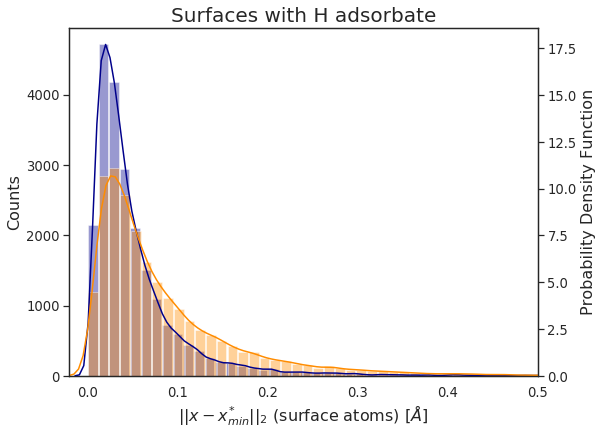

In [157]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8.4, 6.4)})
sns.set(font_scale = 1.2)
# sns.set_style("whitegrid")
sns.set_style("white")

idx = np.where(MAE_non_ads < 0.6)[0]
idx_init = np.where(MAE_non_ads_init < 0.6)[0]

ax = sns.distplot(MAE_non_ads[idx], bins=50, kde=False, norm_hist=False, color='darkblue', label='pred, $x = \hat{x}_{min}$'
                 ,hist_kws={"rwidth":0.9})
ax = sns.distplot(MAE_non_ads_init[idx_init], bins=50, kde=False,norm_hist=False, color='darkorange', label='initial, $x = x_{0}$'
                 ,hist_kws={"rwidth":0.9})


_ = ax.set_xlim(-0.02, 0.5)
_ = ax.set_xlabel('$\||x - x^{*}_{min}\||_{2}$ (surface atoms) [$\AA$]', fontsize=16)
_ = ax.set_ylabel('Counts', fontsize=16)
_ = ax.set_title('Surfaces with H adsorbate', fontsize=20)
# _ = ax.legend(loc='upper right', fontsize=16)
# _ = ax.yaxis.grid(True)
ax2 = ax.twinx()
ax2 = sns.kdeplot(MAE_non_ads[idx], color='darkblue')
ax2 = sns.kdeplot(MAE_non_ads_init[idx_init], color='darkorange')
_ = ax2.set_ylabel('Probability Density Function', fontsize=16)

# plt.xscale('log')
plt.savefig('./H_ads/plot_H.pdf')

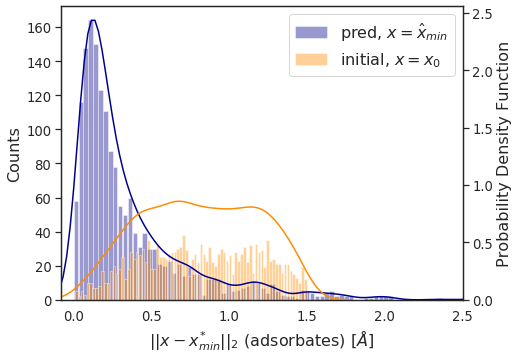

In [158]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7.2, 5.4)})
sns.set(font_scale = 1.2)
# sns.set_style("whitegrid")
sns.set_style("white")

# idx = np.where(MAE_non_ads < 0.6)[0]
# idx_init = np.where(MAE_non_ads_init < 0.6)[0]

ax = sns.distplot(MAE_ads, bins=80, kde=False, norm_hist=False, color='darkblue', label='pred, $x = \hat{x}_{min}$'
                 ,hist_kws={"rwidth":0.9})
ax = sns.distplot(MAE_ads_init, bins=80, kde=False,norm_hist=False, color='darkorange', label='initial, $x = x_{0}$'
                 ,hist_kws={"rwidth":0.9})


_ = ax.set_xlim(-0.08, 2.5)
_ = ax.set_xlabel('$\||x - x^{*}_{min}\||_{2}$ (adsorbates) [$\AA$]', fontsize=16)
_ = ax.set_ylabel('Counts', fontsize=16)
# _ = ax.set_title('Surfaces with H adsorbate', fontsize=20)
_ = ax.legend(loc='upper right', fontsize=16)
# _ = ax.yaxis.grid(True)
ax2 = ax.twinx()
ax2 = sns.kdeplot(MAE_ads, color='darkblue')
ax2 = sns.kdeplot(MAE_ads_init, color='darkorange')
_ = ax2.set_ylabel('Probability Density Function', fontsize=16)

# plt.xscale('log')
plt.savefig('./H_ads/plot_H_ads.pdf')

[23, 49, 27, 0.551, 0.0569, 0.0442, 0.3539, array([0.09533484], dtype=float32)]
2537


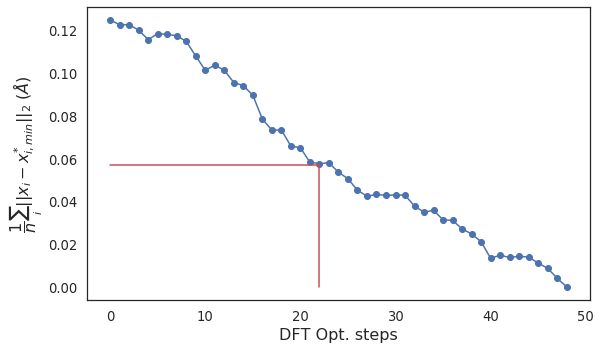

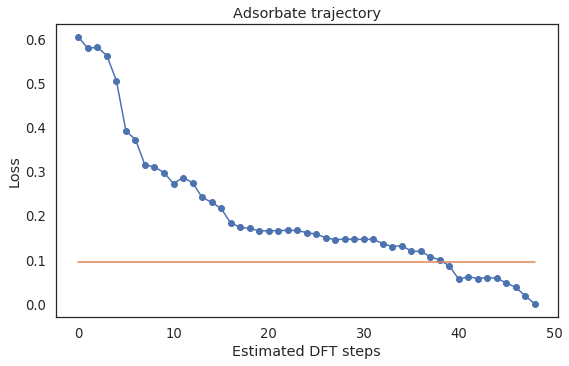

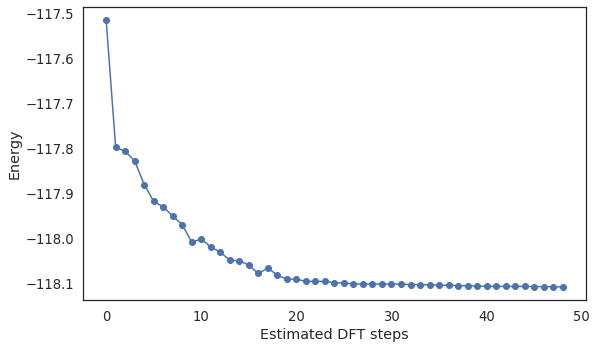

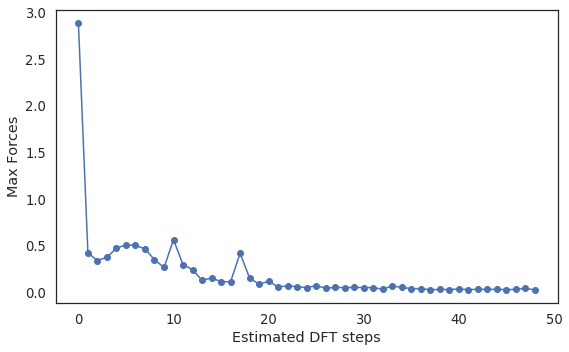

In [40]:
def get_ads_traj(dummy_docs):
    atoms = mongo.make_atoms_from_doc(dummy_docs, is_initial=False)
    ads_idx = int(np.where(atoms.get_tags() == 1)[0])
    ads_pos_final = dummy_docs['positions_per_step'][-1][ads_idx]
    ads_dist = []
    for pos in dummy_docs['positions_per_step']:
        ads_pos = pos[ads_idx]
        ads_dist.append(np.sqrt(np.sum((ads_pos_final - ads_pos)**2)))
    return ads_dist
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(9, 5.4)})
sns.set(font_scale = 1.2)
# sns.set_style("whitegrid")
sns.set_style("white")


i = 21 #21 
print(good_result[i])
print(good_docs[i]['idx'])
plt.plot(good_docs[i]['distances_per_step'], '-o')
steps = np.arange(good_result[i][1])
plt.plot(np.arange(23), [good_result[i][4]]*23, color='r')
plt.plot([22,22], [0,0.057], color='r')
plt.xlabel("DFT Opt. steps", fontsize=16)
plt.ylabel('$\dfrac{1}{n} \sum_i \||x_i - x^{*}_{i,min}\||_{2}$ ($\AA$)', fontsize=16)
plt.savefig('./H_ads/DFT_steps_H.pdf')
plt.show()

ads_traj = get_ads_traj(good_docs[i])
plt.plot(ads_traj, '-o')
plt.plot(steps, [good_result[i][-1]]*len(steps))
plt.ylabel("Loss")
plt.xlabel("Estimated DFT steps")
plt.title('Adsorbate trajectory')
plt.show()


plt.plot(good_docs[i]['energies_per_step'], '-o')
plt.ylabel("Energy")
plt.xlabel("Estimated DFT steps")
plt.show()
plt.plot(np.max(np.max(np.abs(good_docs[i]['forces_per_step']), axis=1), axis=1), '-o')
# plt.plot(np.max(good_docs[i]['forces_per_step'], axis=1), '-o')
plt.ylabel("Max Forces")
plt.xlabel("Estimated DFT steps")
plt.show()


In [29]:
good_idx = np.array(good_result)[:,0].astype(int)
bad_idx = np.array(bad_result)[:,0].astype(int)
# np.random.shuffle(good_idx)

total_atoms = 0
for i in range(len(docs_test)):
    idx = i
    doc = docs_test[idx]
    sdt = SDT_test[idx]
    fixed_base = sdt[-3]
    fixed_atom_idx = np.where(fixed_base == 1)[0]
    free_atom_idx2 = np.where(fixed_base == 0)[0]
    free_atom_idx = sdt[-2]
    assert free_atom_idx2.all() == free_atom_idx.numpy().all()
    num_atoms = len(free_atom_idx)

    init = init_test[total_atoms:total_atoms+num_atoms]
    pred = pred_test[total_atoms:total_atoms+num_atoms]
    true = true_test[total_atoms:total_atoms+num_atoms]
    loss = np.mean(distance_test[total_atoms: total_atoms+num_atoms])
    total_atoms += num_atoms

    if doc['idx'] == 2537:
        print('y')
        atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
        atoms.write('./H_ads/%d_%.4f_initial.traj' %(doc['idx'], loss))
        atoms_f = mongo.make_atoms_from_doc(doc, is_initial=False)
        atoms_f.write('./H_ads/%d_%.4f_final.traj' %(doc['idx'], loss))

        atoms_pred = copy.deepcopy(atoms)
        atoms_pred.positions[free_atom_idx] = pred
        atoms_pred.write('./H_ads/%d_%.4f_pred.traj' %(doc['idx'],loss))
    

y


In [24]:
good_docs[i]['idx']

2537

In [50]:
natoms =[]
types = []
steps = []
distances = []
filtered_idx = []
docs_test_new = []
for doc in docs_test:
    natoms.append(doc['atoms']['natoms'])
    types.extend(doc['atoms']['chemical_symbols'])
    atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
    atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
    if atoms.constraints:
        fixed_atom_idx = atoms.constraints[0].index
        base = np.ones(len(atoms.positions))
        base[fixed_atom_idx] = 0
        free_atom_idx = np.where(base==1)[0]
        
    else:
        free_atom_idx = np.arange(len(atoms))
    difference = atoms.positions[free_atom_idx] - atoms_final.positions[free_atom_idx]
    dist = np.sqrt(np.sum(difference**2, axis=1))
    if np.mean(dist) > 0.06:
        distances.append(dist)
        filtered_idx.append(doc['idx'])

(array([25., 31., 27., 41., 32., 43., 44., 54., 49., 62., 60., 71., 63.,
        56., 52., 54., 59., 54., 60., 43., 39., 46., 54., 47., 37., 41.,
        38., 30., 36., 32., 17., 32., 26., 27., 37., 19., 14., 14.,  7.,
        13., 16., 16.,  8.,  4.,  9.,  7.,  8.,  5.,  8.,  6.]),
 array([0.05000094, 0.05499956, 0.05999818, 0.0649968 , 0.06999542,
        0.07499404, 0.07999266, 0.08499128, 0.0899899 , 0.09498852,
        0.09998714, 0.10498576, 0.10998438, 0.114983  , 0.11998162,
        0.12498024, 0.12997886, 0.13497748, 0.1399761 , 0.14497472,
        0.14997334, 0.15497196, 0.15997058, 0.1649692 , 0.16996782,
        0.17496644, 0.17996506, 0.18496368, 0.1899623 , 0.19496092,
        0.19995954, 0.20495816, 0.20995678, 0.2149554 , 0.21995402,
        0.22495264, 0.22995126, 0.23494988, 0.2399485 , 0.24494712,
        0.24994574, 0.25494436, 0.25994298, 0.2649416 , 0.26994022,
        0.27493884, 0.27993746, 0.28493608, 0.2899347 , 0.29493332,
        0.29993194]),
 <a list of 50

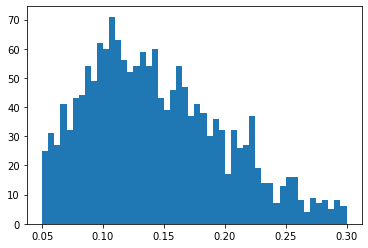

In [42]:
d_mean=[]
for dist in distances:
    d_mean.append(np.mean(dist))
plt.hist(d_mean, bins=50)

In [267]:
good_idx = np.array(good_result)[:,0].astype(int)
bad_idx = np.array(bad_result)[:,0].astype(int)
# np.random.shuffle(good_idx)

total_atoms = 0
for i in range(len(docs_test)):
    idx = i
    doc = docs_test[idx]
    sdt = SDT_test[idx]
    fixed_base = sdt[-3]
    fixed_atom_idx = np.where(fixed_base == 1)[0]
    free_atom_idx2 = np.where(fixed_base == 0)[0]
    free_atom_idx = sdt[-2]
    assert free_atom_idx2.all() == free_atom_idx.numpy().all()
    num_atoms = len(free_atom_idx)

    init = init_test[total_atoms:total_atoms+num_atoms]
    pred = pred_test[total_atoms:total_atoms+num_atoms]
    true = true_test[total_atoms:total_atoms+num_atoms]
    loss = np.mean(distance_test[total_atoms: total_atoms+num_atoms])
    total_atoms += num_atoms

    if doc['idx'] in filtered_idx:
        if doc['data'] == 'surface':
            atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
            atoms.write('./new/traj_surface/initial/%d_%.4f_initial.traj' %(doc['idx'], loss))

            atoms_pred = copy.deepcopy(atoms)
            atoms_pred.positions[free_atom_idx] = pred
            atoms_pred.write('./new/traj_surface/test/%d_%.4f_pred.traj' %(doc['idx'],loss))

        elif doc['data'] == 'slab':
            atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
            atoms.write('./new/traj_slab/initial/%d_%.4f_initial.traj' %(doc['idx'], loss))

            atoms_pred = copy.deepcopy(atoms)
            atoms_pred.positions[free_atom_idx] = pred
            atoms_pred.write('./new/traj_slab/test/%d_%.4f_pred.traj' %(doc['idx'],loss))

In [263]:
doc['idx']

2035

In [24]:
results, reduced, bad_docs, bad_result,good_docs,good_result = analysis(SDT_valid, docs_val, distance_val)

NameError: name 'distance_val' is not defined

Text(0.5, 0, '% Reduced')

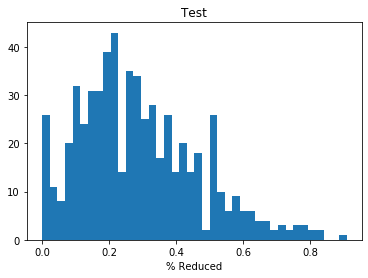

In [133]:
import matplotlib.pyplot as plt
plt.hist(reduced, bins=40)
plt.title("Test")
plt.xlabel("% Reduced")

In [22]:
docs_train[0]['data']

'slab'

In [23]:
f = []
for doc in good_docs:
    f.append(doc['data'])

In [24]:
import collections
collections.Counter(f)

Counter({'surface': 228, 'slab': 367})

In [25]:
np.mean(reduced)

0.27353239056302664

In [152]:
natoms =[]
types = []
steps = []
distances = []
filtered_idx = []
docs_test_new = []
for doc in bad_docs:
    natoms.append(doc['atoms']['natoms'])
    types.extend(doc['atoms']['chemical_symbols'])
    atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
    atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
    if atoms.constraints:
        fixed_atom_idx = atoms.constraints[0].index
        base = np.ones(len(atoms.positions))
        base[fixed_atom_idx] = 0
        free_atom_idx = np.where(base==1)[0]
        
    else:
        free_atom_idx = np.arange(len(atoms))
    difference = atoms.positions[free_atom_idx] - atoms_final.positions[free_atom_idx]
    dist = np.sqrt(np.sum(difference**2, axis=1))
    if np.mean(dist) > 0.05:
        distances.append(dist)
        filtered_idx.append(doc['idx'])

In [153]:
d_mean=[]
for dist in distances:
    d_mean.append(np.mean(dist))

(array([4., 2., 3., 2., 1., 4., 3., 3., 4., 1., 0., 4., 2., 2., 0., 0., 0.,
        4., 2., 2., 3., 2., 1., 1., 3., 1., 4., 2., 2., 0., 1., 0., 1., 0.,
        0., 0., 2., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 3.]),
 array([0.0617567 , 0.06603698, 0.07031727, 0.07459755, 0.07887784,
        0.08315813, 0.08743841, 0.0917187 , 0.09599898, 0.10027927,
        0.10455956, 0.10883984, 0.11312013, 0.11740042, 0.1216807 ,
        0.12596099, 0.13024127, 0.13452156, 0.13880185, 0.14308213,
        0.14736242, 0.15164271, 0.15592299, 0.16020328, 0.16448356,
        0.16876385, 0.17304414, 0.17732442, 0.18160471, 0.18588499,
        0.19016528, 0.19444557, 0.19872585, 0.20300614, 0.20728643,
        0.21156671, 0.215847  , 0.22012728, 0.22440757, 0.22868786,
        0.23296814, 0.23724843, 0.24152872, 0.245809  , 0.25008929,
        0.25436957, 0.25864986, 0.26293015, 0.26721043, 0.27149072,
        0.275771  ]),
 <a list of 50 Patch objects>)

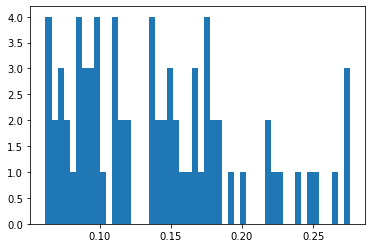

In [154]:
plt.hist(d_mean, bins=50)

(array([7., 6., 8., 2., 7., 4., 2., 2., 2., 4., 6., 2., 5., 1., 4., 4., 2.,
        1., 1., 0., 2., 2., 2., 1., 2., 3., 2., 2., 3., 1., 4., 0., 0., 1.,
        0., 0., 0., 2., 1., 1., 0., 0., 1., 0., 3., 0., 0., 1., 0., 2.]),
 array([0.04034509, 0.04505361, 0.04976213, 0.05447065, 0.05917917,
        0.06388768, 0.0685962 , 0.07330472, 0.07801324, 0.08272176,
        0.08743028, 0.09213879, 0.09684731, 0.10155583, 0.10626435,
        0.11097287, 0.11568138, 0.1203899 , 0.12509842, 0.12980694,
        0.13451546, 0.13922398, 0.14393249, 0.14864101, 0.15334953,
        0.15805805, 0.16276657, 0.16747509, 0.1721836 , 0.17689212,
        0.18160064, 0.18630916, 0.19101768, 0.19572619, 0.20043471,
        0.20514323, 0.20985175, 0.21456027, 0.21926879, 0.2239773 ,
        0.22868582, 0.23339434, 0.23810286, 0.24281138, 0.2475199 ,
        0.25222841, 0.25693693, 0.26164545, 0.26635397, 0.27106249,
        0.275771  ]),
 <a list of 50 Patch objects>)

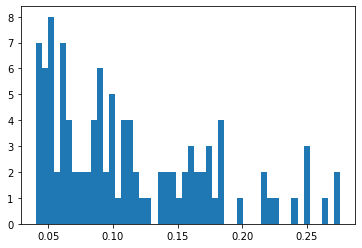

In [33]:
plt.hist(d_mean, bins=50)

In [48]:
len(distances)

158